In [19]:
import re
from typing import List, Tuple, Dict, Any
from nltk import sent_tokenize
from datasets import load_dataset
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [11]:
dataset = load_dataset("khalidrizki/post-retrieval-research_raw-dataset")
train_dataset = dataset['train']
dev_dataset = dataset['dev']
test_dataset = dataset['test']
print('selesai memuat dataset...')

selesai memuat dataset...


In [ ]:
def split_between_title_and_text(text: str) -> Tuple[str, str]:
    """Memisahkan bagian Judul dan Teks dari input lengkap."""
    title, content = text.split("|", 1)
    return title.strip(), content.strip()

def split_sentences(text: str):
    # Hapus sitasi dalam format [1], [2], dst.
    cleaned_text = re.sub(r'\[\d+\]', '', text)
    
    # Jalankan sentence tokenizer dari nltk
    sentences = sent_tokenize(cleaned_text)
    
    return [s.strip() for s in sentences if s.strip()]

def create_rolling_segments(title: str, sentences: List[str], window_size: int = 3, stride: int = 2) -> List[str]:
    segments = []
    if len(sentences) < window_size:
        segments.append(f"{title} | {' '.join(sentences)}")
    else:
        for i in range(0, len(sentences) - window_size + 1, stride):
            group = sentences[i:i + window_size]
            combined = title + " | " + " ".join(group)
            segments.append(combined)
    return segments

def prepare_context_chunks(text: str, is_positive: bool) -> List[Dict[str, Any]]:
    """Memproses teks menjadi rolling segments, disertai label apakah positive passage."""
    title, content = split_between_title_and_text(text)
    sentences = split_sentences(content)
    segments = create_rolling_segments(title, sentences, window_size=3)
    
    return [{"text": seg, "is_positive": is_positive} for seg in segments]


def split_each_passages(example):
    passages = example["passages"]
    all_chunks = []
    all_labels = []

    for i, passage in enumerate(passages):
        is_positive = (i == 0)  # Index 0 = positive passage
        chunks = prepare_context_chunks(passage, is_positive)
        for c in chunks:
            all_chunks.append(c["text"])
            all_labels.append(c["is_positive"])

    return {
        "context_chunks": all_chunks,
        "chunk_labels": all_labels
    }

train_dataset = train_dataset.map(split_each_passages)
dev_dataset = dev_dataset.map(split_each_passages)
test_dataset = test_dataset.map(split_each_passages)
print('selesai membuat chunks...')

Map:   0%|          | 0/4542 [00:00<?, ? examples/s]

Map: 100%|██████████| 565/565 [00:00<00:00, 2000.93 examples/s]

selesai membuat chunks...


In [25]:
total_chunks = sum(len(row["context_chunks"]) for row in train_dataset)
average_chunks = total_chunks / len(train_dataset)
print(f"Rerata jumlah elemen di 'context_chunks' TRAIN: {average_chunks:.2f}")

dev_chunks = sum(len(row["context_chunks"]) for row in dev_dataset)
average_dev_chunks = dev_chunks / len(dev_dataset)
print(f"Rerata jumlah elemen di 'context_chunks' DEV: {average_dev_chunks:.2f}")

test_chunks = sum(len(row["context_chunks"]) for row in test_dataset)
average_test_chunks = test_chunks / len(test_dataset)
print(f"Rerata jumlah elemen di 'context_chunks' TEST: {average_test_chunks:.2f}")

Rerata jumlah elemen di 'context_chunks' TRAIN: 4.77
Rerata jumlah elemen di 'context_chunks' DEV: 4.52
Rerata jumlah elemen di 'context_chunks' TEST: 4.61


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-small')
model.eval()

# Fungsi pooling dari model card
def average_pool(last_hidden_states, attention_mask):
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

from typing import Optional
def get_all_units_scores_sorted(query, units, labels):
    if not units:
        return []

    input_texts = ["query: " + query] + ["passage: " + u for u in units]
    batch = tokenizer(input_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**batch)

    embeddings = average_pool(outputs.last_hidden_state, batch['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)

    query_embedding = embeddings[0]
    unit_embeddings = embeddings[1:]
    scores = (query_embedding @ unit_embeddings.T) * 100

    scores_list = scores.tolist()

    combined = [{"text": units[i], "score": scores_list[i], "is_positive": labels[i]} for i in range(len(units))]
    combined_sorted = sorted(combined, key=lambda x: x["score"], reverse=True)
    return combined_sorted

def process_dataset_with_sorted_scores(
    dataset, 
    text_col: str,
    label_col: Optional[str] =None,
    output_col: str=None
):
    ranked_units_all = []

    for example in tqdm(dataset, desc=f"Processing {output_col}"):
        query = example['query']

        if label_col is None:
            units = example[text_col]
            labels = [i == 0 for i in range(len(units))]            
        else:
            units = example[text_col]
            labels = example[label_col]            

        ranked_units = get_all_units_scores_sorted(query, units, labels)
        ranked_units_all.append(ranked_units)

    dataset = dataset.add_column(output_col, ranked_units_all)
    return dataset

In [ ]:
from datasets import DatasetDict
# Membuat chunks dan me-ranking berdasarkan skor similarity
train_dataset = process_dataset_with_sorted_scores(train_dataset, text_col="context_chunks", label_col="chunk_labels", output_col="ranked_chunks_with_labels")
dev_dataset = process_dataset_with_sorted_scores(dev_dataset, text_col="context_chunks", label_col="chunk_labels", output_col="ranked_chunks_with_labels")
test_dataset = process_dataset_with_sorted_scores(test_dataset, text_col="context_chunks", label_col="chunk_labels", output_col="ranked_chunks_with_labels")

dataset = DatasetDict({
    "train": train_dataset,
    "dev": dev_dataset,
    "test": test_dataset
})

# Me-rangking passages berdasarkan skor similarity
for split in dataset.keys():
    dataset[split] = process_dataset_with_sorted_scores(
    dataset[split], 
    text_col="passages",
    output_col="ranked_passages_with_labels"
)

In [37]:
dataset.save_to_disk('../generated_data/CRAG_dataset')

Saving the dataset (1/1 shards): 100%|██████████| 565/565 [00:00<00:00, 46627.22 examples/s]


# EDA 

## 1. Jumlah Chunks tiap Row

In [67]:
from collections import Counter

def count_number_of_chunks_per_query(dataset):
    freq_counter = Counter()
    total_chunks = 0

    for ex in dataset:
        labels = ex['chunk_labels']
        n_chunks = len(labels)
        freq_counter[n_chunks] += 1
        total_chunks += n_chunks

    avg_chunks_per_query = total_chunks / len(dataset)
    return dict(freq_counter), avg_chunks_per_query

train_chunks_dist, avg_train_chunks = count_number_of_chunks_per_query(train_dataset)
print(f"Rerata jumlah elemen di 'context_chunks' TRAIN: {avg_train_chunks:.2f}")
print('\n'.join([f"{n} chunks: {c} query ({c/len(train_dataset)*100:.2f}%)" for n, c in sorted(train_chunks_dist.items())]))
print()
dev_chunks_dist, avg_dev_chunks = count_number_of_chunks_per_query(dev_dataset)
print(f"Rerata jumlah elemen di 'context_chunks' DEV: {avg_dev_chunks:.2f}")
print('\n'.join([f"{n} chunks: {c} query ({c/len(dev_dataset)*100:.2f}%)" for n, c in sorted(dev_chunks_dist.items())]))
print()
test_chunks_dist, avg_test_chunks = count_number_of_chunks_per_query(test_dataset)
print(f"Rerata jumlah elemen di 'context_chunks' TEST: {avg_test_chunks:.2f}")
print('\n'.join([f"{n} chunks: {c} query ({c/len(test_dataset)*100:.2f}%)" for n, c in sorted(test_chunks_dist.items())]))

Rerata jumlah elemen di 'context_chunks' TRAIN: 4.77
3 chunks: 1491 query (32.83%)
4 chunks: 1154 query (25.41%)
5 chunks: 731 query (16.09%)
6 chunks: 470 query (10.35%)
7 chunks: 294 query (6.47%)
8 chunks: 161 query (3.54%)
9 chunks: 87 query (1.92%)
10 chunks: 44 query (0.97%)
11 chunks: 42 query (0.92%)
12 chunks: 20 query (0.44%)
13 chunks: 13 query (0.29%)
14 chunks: 10 query (0.22%)
15 chunks: 5 query (0.11%)
16 chunks: 4 query (0.09%)
17 chunks: 1 query (0.02%)
18 chunks: 1 query (0.02%)
19 chunks: 3 query (0.07%)
21 chunks: 2 query (0.04%)
23 chunks: 2 query (0.04%)
25 chunks: 2 query (0.04%)
26 chunks: 1 query (0.02%)
27 chunks: 2 query (0.04%)
44 chunks: 1 query (0.02%)
48 chunks: 1 query (0.02%)

Rerata jumlah elemen di 'context_chunks' DEV: 4.52
3 chunks: 415 query (36.31%)
4 chunks: 328 query (28.70%)
5 chunks: 153 query (13.39%)
6 chunks: 98 query (8.57%)
7 chunks: 74 query (6.47%)
8 chunks: 35 query (3.06%)
9 chunks: 15 query (1.31%)
10 chunks: 10 query (0.87%)
11 chun

## 2. Jumlah Chunks Positif tiap Row

In [56]:
from collections import Counter

def count_positive_chunks_per_query(dataset):
    """
    Menghitung distribusi jumlah chunk positif per query,
    serta rata-rata jumlah chunk positif di seluruh dataset.

    Parameters:
    - dataset: Dataset Huggingface atau list of dict dengan kolom 'chunk_labels'

    Returns:
    - freq_counter: dict {jumlah_positif: banyak_query}
    - avg_positive_per_query: float
    """
    freq_counter = Counter()
    total_positives = 0

    for ex in dataset:
        labels = ex['chunk_labels']
        n_positive = sum(labels)
        freq_counter[n_positive] += 1
        total_positives += n_positive

    avg_positive_per_query = total_positives / len(dataset)
    return dict(freq_counter), avg_positive_per_query

In [ ]:
dist, avg = count_positive_chunks_per_query(train_dataset)
print("Distribusi jumlah chunk positif per row:")
for n_pos, count in sorted(dist.items()):
    print(f"{n_pos} positif: {count} query")

print(f"\nRata-rata chunk positif per row: {avg:.2f}")

Distribusi jumlah chunk positif per row:
1 positif: 3034 query
2 positif: 911 query
3 positif: 358 query
4 positif: 129 query
5 positif: 50 query
6 positif: 25 query
7 positif: 11 query
8 positif: 6 query
9 positif: 5 query
10 positif: 1 query
12 positif: 5 query
14 positif: 1 query
15 positif: 1 query
21 positif: 2 query
23 positif: 1 query
41 positif: 1 query
46 positif: 1 query

Rata-rata chunk positif per row: 1.60


## 3. Distribusi Skor Similarity

In [33]:
import matplotlib.pyplot as plt

def plot_score_distribution_by_label(dataset, sample_size=100, bins=30, use_median=False, show_ticks = True):
    pos_scores, neg_scores = [], []
    avg_label = ""

    for ex in dataset.select(range(sample_size)):
        for item in ex['ranked_chunks_with_labels']:
            if item['is_positive']:
                pos_scores.append(item['score'])
            else:
                neg_scores.append(item['score'])

    # Hitung rerata
    if use_median:
        import numpy as np
        pos_avg = np.median(pos_scores)
        neg_avg = np.median(neg_scores)
        avg_label = 'med'
    else:
        pos_avg = sum(pos_scores) / len(pos_scores)
        neg_avg = sum(neg_scores) / len(neg_scores)
        avg_label='mean'

    plt.figure(figsize=(10, 6))
    plt.hist(pos_scores, bins=bins, alpha=0.6, color='green', label='Positive', density=True)
    plt.hist(neg_scores, bins=bins, alpha=0.6, color='red', label='Negative', density=True)

    # Garis putus-putus untuk rerata
    plt.axvline(pos_avg, color='green', linestyle='--', linewidth=2, label=f'Pos {avg_label}: {pos_avg:.2f}')
    plt.axvline(neg_avg, color='red', linestyle='--', linewidth=2, label=f'Neg {avg_label}: {neg_avg:.2f}')

    if show_ticks:
        current_ticks = plt.xticks()[0].tolist()
        extra_ticks = [round(pos_avg, 2), round(neg_avg, 2)]
        plt.xticks(sorted(set(current_ticks + extra_ticks)))

    plt.title("Distribusi Skor Similarity Positive vs Negative Chunks")
    plt.xticks(rotation=45)
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


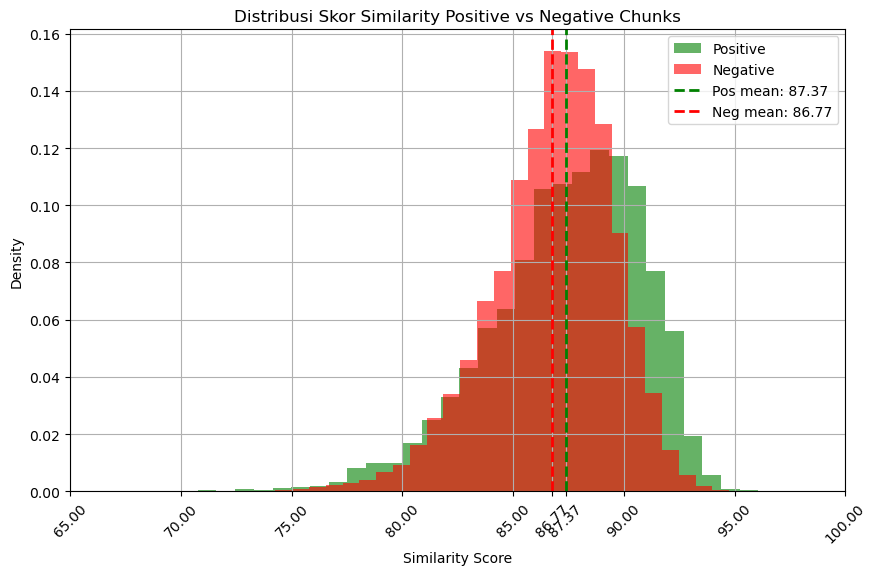

In [34]:
plot_score_distribution_by_label(train_dataset, sample_size = len(train_dataset))

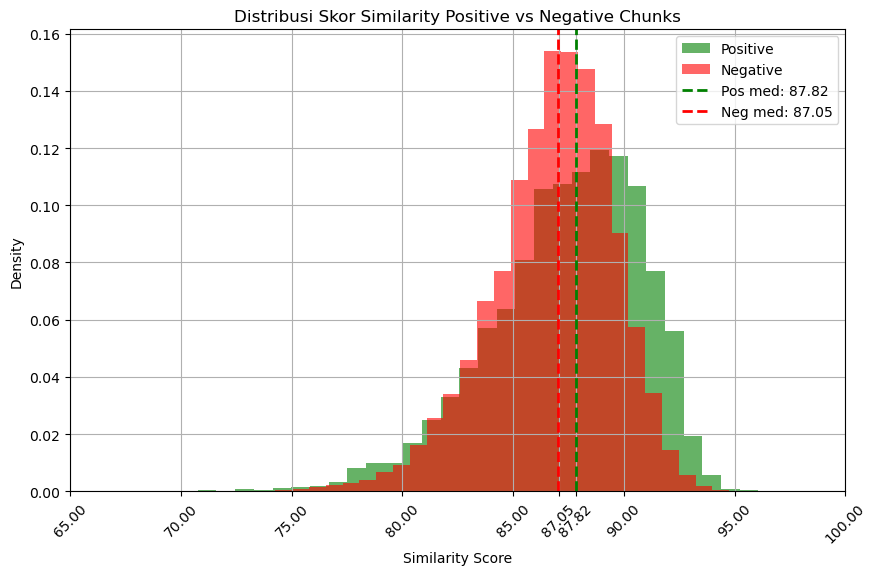

In [35]:
plot_score_distribution_by_label(train_dataset, sample_size = len(train_dataset), use_median=True)

## 4. Presisi 
Apakah dari chunks yang diambil, semua/mayoritas relevan?

In [40]:
def precision_at_k(dataset, k=1):
    precisions = []
    for ex in dataset:
        topk = ex['ranked_chunks_with_labels'][:k]
        n_pos = sum(1 for item in topk if item['is_positive'])
        precisions.append(n_pos / k)
    return sum(precisions) / len(precisions)

In [41]:
precision_at_k(train_dataset, k=1)

0.5763980625275209

In [43]:
precision_at_k(train_dataset, k=2)

0.39993394980184943

In [44]:
precision_at_k(train_dataset, k=5)

0.2726552179656539

## 5. Distribusi Rank Positif Pertama

In [46]:
from collections import Counter

def get_positive_rank_distribution(dataset, max_rank=None):
    """
    Mengembalikan distribusi posisi ranking dari positive chunk pertama
    di setiap query dalam dataset.

    Parameters:
    - dataset: dataset Huggingface atau list of dict
    - max_rank: jika ingin membatasi pencarian sampai rank tertentu saja

    Returns:
    - Counter dengan kunci posisi (1-based) dan nilai jumlah kemunculan
    """
    position_counts = Counter()

    for example in dataset:
        found = False
        for idx, item in enumerate(example['ranked_chunks_with_labels']):
            if max_rank is not None and idx >= max_rank:
                break
            if item['is_positive']:
                position_counts[idx + 1] += 1  # rank = index + 1
                found = True
                break
        if not found:
            position_counts['>max'] += 1  # fallback jika tidak ditemukan (opsional)

    return dict(position_counts)


In [52]:
import matplotlib.pyplot as plt

def plot_positive_rank_distribution(rank_dist, title="Distribusi Posisi Chunk Positif Pertama"):
    """
    Membuat bar chart dari distribusi posisi ranking positif pertama.

    Parameters:
    - rank_dist: dict hasil dari get_positive_rank_distribution
    - title: judul plot
    """
    # Pisahkan nilai numerik dan non-numerik ('>max') jika ada
    numeric_ranks = {k: v for k, v in rank_dist.items() if isinstance(k, int)}
    special_ranks = {k: v for k, v in rank_dist.items() if not isinstance(k, int)}

    # Gabungkan dan urutkan
    sorted_ranks = sorted(numeric_ranks.items()) + list(special_ranks.items())

    labels = [str(k) for k, _ in sorted_ranks]
    values = [v for _, v in sorted_ranks]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(labels, values, color='skyblue')

    plt.xlabel("Posisi Ranking Positif Pertama (1-based)")
    plt.ylabel("Jumlah Query")
    plt.title(title)

    # Tambahkan label angka di atas bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


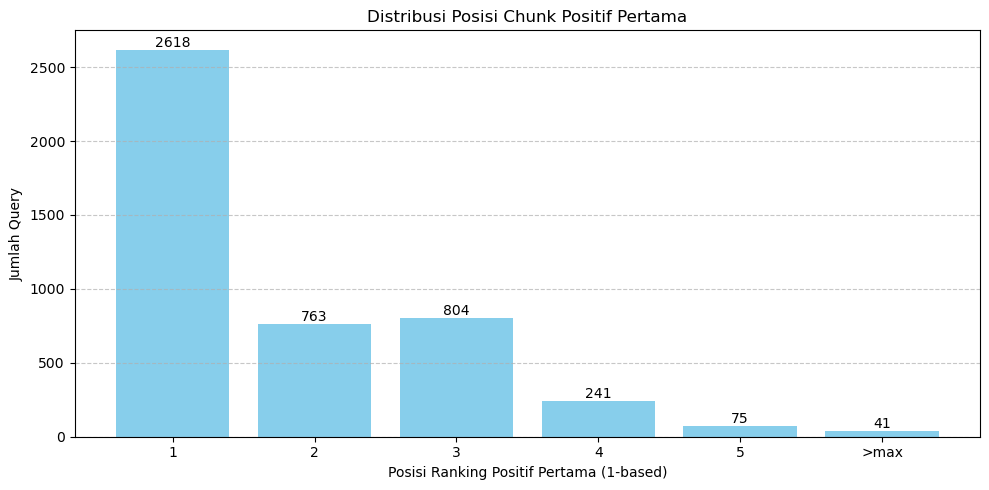

In [53]:
# Tanpa batasan rank
dist = get_positive_rank_distribution(train_dataset, max_rank=5)
plot_positive_rank_distribution(dist)

In [72]:
train_dataset['ranked_chunks_with_labels'][2967]

[{'is_positive': False,
  'score': 91.0045394897461,
  'text': 'Taman Nasional Ujung Kulon | Melalui Keputusan Menteri Kehutanan Nomor: 284/Kpts-II/1992 Tanggal 26 Februari 1992, Ujung Kulon ditunjuk sebagai Taman Nasional Ujung Kulon dengan luas total 122.956 Ha terdiri dari kawasan darat 78.619 Ha dan perairan 44.337 Ha.'},
 {'is_positive': False,
  'score': 89.75101470947266,
  'text': 'Taman Nasional Ujung Kulon | Komisi Warisan Dunia UNESCO menetapkan Taman Nasional Ujung Kulon sebagai Natural World Heritage Site (Situs Warisan Alam Dunia) dengan Surat Keputusan Nomor: SC/Eco/5867.2.409 Tanggal 1 Februari 1992.'},
 {'is_positive': True,
  'score': 88.17350006103516,
  'text': 'Taman Nasional Ujung Kulon | Ujung Kulon merupakan taman nasional tertua di Indonesia yang sudah diresmikan sebagai salah satu Warisan Dunia yang dilindungi oleh UNESCO pada tahun 1991, karena wilayahnya mencakupi hutan lindung yang sangat luas. Sampai saat ini kurang lebih 50 sampai dengan 60 badak hidup di

# Membuat Jawaban

In [51]:
import sys
sys.path.append('../RECOMP')
# from generate_answer import generate_answer_and_do_scoring
from utils import load_model_and_tokenizer
model_name='Qwen/Qwen3-1.7B'
model, tokenizer, config = load_model_and_tokenizer(model_name)

Loading model on cuda with torch.bfloat16


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


In [ ]:
from datasets import load_from_disk
dataset_path = "../generated_data/CRAG_dataset"
dataset = load_from_disk(dataset_path)
test_dataset = dataset['test']

In [ ]:
from functools import partial

def extract_topk_text_and_full_passages(example, k=3, ranked_units='ranked_chunks_with_labels'):
    ranked_chunks = example[ranked_units]
    
    # Ambil top-k chunk (atau kurang jika tersedia lebih sedikit)
    topk_chunks = ranked_chunks[:k]
    
    # Gabungkan semua 'text' dari top-k dengan pemisah newline
    joined_text = "\n".join(chunk['text'] for chunk in topk_chunks)
    topk_labels = [chunk['is_positive'] for chunk in topk_chunks]

    return {
        f"top{k}_chunks": joined_text,
        f"top{k}_labels": topk_labels
    }

## Dengan Top 1 Chunks

In [64]:
# Top-k bisa kamu sesuaikan di sini
k = 1
extract_fn = partial(extract_topk_text_and_full_passages, k=k)
test_dataset = test_dataset.map(extract_fn)


In [65]:
top1_generation = generate_answer_and_do_scoring(
    dataset=test_dataset,
    query_col="query",
    filtered_contexts_col="top1_chunks",
    original_passages_col='ranked_chunks_with_labels',
    label_col="answer",
    model=model,
    tokenizer=tokenizer
)

Generating responses with summary only:   0%|          | 0/565 [00:00<?, ?it/s]c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset

In [66]:
# Attempt: truncate filtered_context so it fits 512
from datasets import Dataset
CRAG_top1 = Dataset.from_list(top1_generation)
print("HASIL CRAG dengan Top 1")
print("rerata EM:", sum(CRAG_top1['em'])/len(CRAG_top1))
print("rerata F1:", sum(CRAG_top1['f1'])/len(CRAG_top1))

HASIL CRAG dengan Top 1
rerata EM: 0.46194690265486726
rerata F1: 0.3076654654081876


__"Jawab dalam dua kalimat"__

rerata EM: 0.46194690265486726

rerata F1: 0.3076654654081876

__"Jawab pertanyaan berikut"__

rerata EM: 0.45132743362831856

rerata F1: 0.2531249458778981

In [74]:
CRAG_top1.save_to_disk('./generated_data/top1_assuredQuery')

Saving the dataset (1/1 shards): 100%|██████████| 565/565 [00:00<00:00, 35401.58 examples/s]


## Dengan Top 2 Chunks

In [67]:
extract2_fn = partial(extract_topk_text_and_full_passages, k=2)
test_dataset = test_dataset.map(extract2_fn)
test_dataset

Dataset({
    features: ['query_id', 'query', 'tydiqa_id', 'answer', 'passages', 'context_chunks', 'chunk_labels', 'ranked_chunks_with_labels', 'top1_chunks', 'top1_labels', 'top2_chunks', 'top2_labels'],
    num_rows: 565
})

In [68]:
top2_answers = generate_answer_and_do_scoring(
    dataset=test_dataset,
    query_col="query",
    filtered_contexts_col="top2_chunks",
    original_passages_col='ranked_chunks_with_labels',
    label_col="answer",
    model=model,
    tokenizer=tokenizer
)

Generating responses with summary only:   0%|          | 0/565 [00:00<?, ?it/s]c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset

In [69]:
from datasets import Dataset
CRAG_top2 = Dataset.from_list(top2_answers)
print("HASIL CRAG dengan Top 2")
print("rerata EM:", sum(CRAG_top2['em'])/len(CRAG_top2))
print("rerata F1:", sum(CRAG_top2['f1'])/len(CRAG_top2))

HASIL CRAG dengan Top 2
rerata EM: 0.5451327433628319
rerata F1: 0.34767403844806855


__"Jawab pertanyaan dalam dua kalimat"__

rerata EM: 0.5380530973451327

rerata F1: 0.34436598956479847

__"Jawab pertanyaan berikut"__

rerata EM: 0.5238938053097345

rerata F1: 0.2812378673810715

In [77]:
CRAG_top2

Dataset({
    features: ['query', 'filtered_context', 'label', 'generated_answer', 'em', 'f1', 'prompt_token_length', 'was_truncated', 'final_prompt', 'final_prompt_decoded', 'full_decoded_output', 'passages'],
    num_rows: 565
})

In [78]:
CRAG_top2.save_to_disk('./generated_data/top2_assuredQuery')

Saving the dataset (1/1 shards): 100%|██████████| 565/565 [00:00<00:00, 44878.83 examples/s]


## Dengan Top 3 Chunks

In [70]:
extract3_fn = partial(extract_topk_text_and_full_passages, k=3)
test_dataset = test_dataset.map(extract3_fn)
top3_answers = generate_answer_and_do_scoring(
    dataset=test_dataset,
    query_col="query",
    filtered_contexts_col="top3_chunks",
    original_passages_col='ranked_chunks_with_labels',
    label_col="answer",
    model=model,
    tokenizer=tokenizer
)

Generating responses with summary only: 100%|██████████| 565/565 [21:30<00:00,  2.28s/it]


__"Jawab pertanyaan dalam dua kalimat"__

rerata EM: 0.5256637168141592

rerata F1: 0.33914371557823864

__"Jawab pertanyaan berikut"__

rerata EM: 0.5203539823008849

rerata F1: 0.2702114031039669

In [71]:
# Latest attempt
CRAG_top3 = Dataset.from_list(top3_answers)
print("HASIL CRAG dengan chunks top 3")
print("rerata EM:", sum(CRAG_top3['em'])/len(CRAG_top3))
print("rerata F1:", sum(CRAG_top3['f1'])/len(CRAG_top3))

HASIL CRAG dengan chunks top 3
rerata EM: 0.5911504424778761
rerata F1: 0.36747370967665716


In [75]:
CRAG_top3.save_to_disk('./generated_data/top3_assuredQuery')

Saving the dataset (1/1 shards): 100%|██████████| 565/565 [00:00<00:00, 38623.47 examples/s]


## Dengan Semua Chunks
Tapi tetap maksimal panjang input ditetapkan sebagai 512 token

Melakukan generasi jawaban dengan semua chunks, diurutkan dari paling tinggi skor similarity-nya

In [72]:
extract_all_fn = partial(extract_topk_text_and_full_passages, k=99)
test_dataset = test_dataset.map(extract_all_fn)

all_chunk_answers = generate_answer_and_do_scoring(
    dataset=test_dataset,
    query_col="query",
    filtered_contexts_col="top99_chunks",
    original_passages_col='ranked_chunks_with_labels',
    label_col="answer",
    model=model,
    tokenizer=tokenizer
)
ds = Dataset.from_list(all_chunk_answers)

Generating responses with summary only: 100%|██████████| 565/565 [21:26<00:00,  2.28s/it]


In [73]:
long_inputs = ds.filter(lambda x: x["was_truncated"])
short_inputs = ds.filter(lambda x: not x["was_truncated"])

if len(long_inputs) > 0:
    print("Long Input Avg F1:", sum([r["f1"] for r in long_inputs]) / len(long_inputs))
    print("Long Input Avg EM:", sum([r["em"] for r in long_inputs]) / len(long_inputs))
print("Short Input Avg F1:", sum([r["f1"] for r in short_inputs]) / len(short_inputs))
print("Short Input Avg EM:", sum([r["em"] for r in short_inputs]) / len(short_inputs))

Filter: 100%|██████████| 565/565 [00:00<00:00, 11590.56 examples/s]


Long Input Avg F1: 0.0
Long Input Avg EM: 0.0
Short Input Avg F1: 0.37027166749336476
Short Input Avg EM: 0.5939716312056738


__Ketika query belum tentu masuk ke dalam prompt__

Long Input Avg EM: 0.08996539792387544

Short Input Avg EM: 0.5978260869565217

In [76]:
ds.save_to_disk('./generated_data/all_assuredQuery')

Saving the dataset (1/1 shards): 100%|██████████| 565/565 [00:00<00:00, 38419.34 examples/s]


## RAG Normal

In [41]:
from datasets import load_from_disk
dataset = load_from_disk('../generated_data/CRAG_dataset')
test_dataset = dataset['test']

In [45]:
extract_all_fn = partial(extract_topk_text_and_full_passages, k=3, ranked_units='ranked_passages_with_labels')
test_dataset = test_dataset.map(extract_all_fn)

Map: 100%|██████████| 565/565 [00:00<00:00, 3251.19 examples/s]


In [52]:
all_passages_answers = generate_answer_and_do_scoring(
    dataset= test_dataset,
    query_col = 'query', 
    filtered_contexts_col = 'top3_chunks',
    label_col = 'answer', 
    model = model,
    tokenizer = tokenizer,
    original_passages_col='ranked_passages_with_labels', 
    verbose = True
)

normal_RAG = Dataset.from_list(all_passages_answers)

Generating responses with summary only:   0%|          | 0/565 [00:00<?, ?it/s]c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\transformers\generation\configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset

In [54]:
long_inputs = normal_RAG.filter(lambda x: x["was_truncated"])
short_inputs = normal_RAG.filter(lambda x: not x["was_truncated"])

if len(long_inputs) > 0:
    print(f'terdapat {len(long_inputs)} row yang kemungkinan query / "Assistant" nya terpotong')
    print("Long Input Avg F1:", sum([r["f1"] for r in long_inputs]) / len(long_inputs))
    print("Long Input Avg EM:", sum([r["em"] for r in long_inputs]) / len(long_inputs))
print("Short Input Avg F1:", sum([r["f1"] for r in short_inputs]) / len(short_inputs))
print("Short Input Avg EM:", sum([r["em"] for r in short_inputs]) / len(short_inputs))

Filter: 100%|██████████| 565/565 [00:00<00:00, 11429.94 examples/s]


terdapat 1 row yang kemungkinan query / "Assistant" nya terpotong
Long Input Avg F1: 0.0
Long Input Avg EM: 0.0
Short Input Avg F1: 0.36616952920899787
Short Input Avg EM: 0.5833333333333334


In [55]:
normal_RAG.save_to_disk('./generated_data/normal_rag')

Saving the dataset (1/1 shards): 100%|██████████| 565/565 [00:00<00:00, 29715.13 examples/s]


# Playground

In [1]:
import sys 
sys.path.append('../RECOMP')
from datasets import Dataset
from functools import partial

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from utils import format_chat_prompt, detect_device, DeviceType
from generate_answer import evaluate_em_f1
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import Optional, Union, Tuple, Dict, List, Any
import torch
from tqdm import tqdm

def prepare_inputs(
    text: str,
    tokenizer: AutoTokenizer,
    device_type: DeviceType, 
    max_length: int = None,
    return_decoded_prompt: bool = False
) -> Union[Tuple[Dict[str, torch.Tensor], int, bool],
           Tuple[Dict[str, torch.Tensor], int, bool, str]]:
    """
    Prepare model inputs with proper device placement,
    return token length, truncation info,
    and optionally the decoded final input.
    """
    tokenize_kwargs = {}
    if max_length is not None:
        tokenize_kwargs['max_length'] = max_length

    # Tokenize only for length-checking
    encoding = tokenizer(
        text,
        add_special_tokens=False,
        truncation=False,
        return_tensors="pt"
    )
    token_length = encoding["input_ids"].shape[1]
    is_truncated = token_length > max_length if max_length else False

    # Tokenize for model input (with truncation)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        add_special_tokens=False,
        **tokenize_kwargs
    )

    device = device_type.value
    inputs = {k: v.to(device) for k, v in inputs.items()}

    if return_decoded_prompt:
        decoded_prompt = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
        return inputs, token_length, is_truncated, decoded_prompt
    else:
        return inputs, token_length, is_truncated

def truncate_context_to_fit_prompt(
    filtered_context: str,
    query: str,
    tokenizer: AutoTokenizer,
    max_source_length: int
) -> str:
    raw_instruction = f"Konteks: \nBerdasarkan konteks, jawab pertanyaan dalam dua kalimat. Pertanyaan: {query}"
    instruction_prefix = format_chat_prompt([{"role": "user", "content": raw_instruction}], tokenizer)
    instruction_len = len(tokenizer(instruction_prefix, add_special_tokens=False)["input_ids"])
    available_len = max_source_length - instruction_len

    truncated_context_ids = tokenizer(
        filtered_context,
        max_length=available_len,
        truncation=True,
        add_special_tokens=False
    )["input_ids"]

    return tokenizer.decode(truncated_context_ids, skip_special_tokens=True)

def generate_completion(
    filtered_context: str,
    query: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    device_type: str,
    max_new_tokens: int = 50,
    max_source_length: int = 512
) -> Tuple[str, int, bool, str]:  # Tambahkan prompt (str)
    truncated_context = truncate_context_to_fit_prompt(
        filtered_context=filtered_context,
        query=query,
        tokenizer=tokenizer,
        max_source_length=max_source_length
    )

    prompt = f"Konteks: {truncated_context}\nBerdasarkan konteks, jawab pertanyaan dalam dua kalimat. Pertanyaan: {query}"
    formatted_prompt = format_chat_prompt([{"role": "user", "content": prompt}], tokenizer)

    inputs, token_length, was_truncated, decoded_prompt = prepare_inputs(
        formatted_prompt, tokenizer, device_type, max_length=max_source_length, return_decoded_prompt=True
    )

    input_ids = inputs["input_ids"]
    output = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id,
        return_dict_in_generate=True
    )
    generated_ids = output.sequences[0][len(input_ids[0]):]
    completion = tokenizer.decode(generated_ids, skip_special_tokens=True)
    full_decoded_output = tokenizer.decode(output.sequences[0], skip_special_tokens=False)

    return completion, token_length, was_truncated, prompt, decoded_prompt, full_decoded_output

def generate_answer_and_do_scoring(
    dataset: Dataset,
    query_col: str, 
    filtered_contexts_col: str,
    label_col: str, 
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    original_passages_col: Optional[Union[str, List[Any]]] = None, 
    max_new_tokens: int = 52, 
    max_source_length: int = 512,
    verbose: bool = False
):
    config = detect_device()
    results = []

    for i in tqdm(range(len(dataset)), desc="Generating responses with summary only"):
        query = dataset[query_col][i]
        filtered_context = dataset[filtered_contexts_col][i]
        label = dataset[label_col][i]
        if original_passages_col is not None:
            original_passages = dataset[original_passages_col][i]

        completion, token_len, was_truncated, prompt, decoded_prompt, full_decoded_output = generate_completion(
            filtered_context, query, model, tokenizer, config.device_type, max_new_tokens, max_source_length
        )

        em, f1 = evaluate_em_f1(completion.strip(), label.strip())

        # Core result
        result = {
            "query": query,
            "filtered_context": filtered_context,
            "label": label,
            "generated_answer": completion,
            "em": em,
            "f1": f1
        }

        if original_passages_col is not None:
            result["passages"] = original_passages

        # Tambahan hanya jika verbose=True
        if verbose:
            result.update({
                "prompt_token_length": token_len,
                "was_truncated": was_truncated,
                "final_prompt": prompt, 
                "final_prompt_decoded": decoded_prompt, 
                "full_decoded_output": full_decoded_output
            })

        results.append(result)

    return results